### Task 2: Temporal Network Analysis
* Degree (in-degree/out-degree)
* Dyads and Reciprocity

A temporal network is goint to be analysed which consists of 678907 vertices and 4729035 edges, where each edge has time information associated with it. Some of the edges have the same source and target vertex, but are association with different timestamps. These timestamps are going to be used in this temporal netwrok analysis to asses and evaluate the evolution of grapg properties by analyzing the changes of the devised measuredby by exploring different time intervals and scales which define time windows to be used.

### <font color="darkgreen">Imports, configuation and preprocessing</font>

In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
import igraph
import datetime

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [5]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [6]:
temp_nw.head()

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44


In [49]:
wiki = open("data/tgraph_real_wikiedithyperlinks_noTime.txt", 'rb')
G = nx.read_edgelist(wiki, create_using=nx.DiGraph())
wiki.close()

In [50]:
def create_dataframe(G_in):
    df_edge_in = pd.DataFrame(list(G_in.in_degree()), columns=['node', 'in edges'])
    df_edge_out = pd.DataFrame(list(G_in.out_degree()), columns=['node', 'out edges'])
    df_total = pd.merge(df_edge_in, df_edge_out, on='node')
    df_total.index = df_total.index + 1
    return df_total

In [54]:
wiki_df = create_dataframe(G)

We assume that the most changes will be tracked over course of months or years. Let's create a timestamp for every year: $T_i = $ 2002$+i$-01-01 00:00:00.

In [7]:
# Create timestamps
dTime={}
for x in range(0,11):
    year = 2002 + x
    T = datetime.datetime(year, 1, 1, 0, 0, 0)
    dTime["T{0}".format(x)]=T
dTime

{'T0': datetime.datetime(2002, 1, 1, 0, 0),
 'T1': datetime.datetime(2003, 1, 1, 0, 0),
 'T10': datetime.datetime(2012, 1, 1, 0, 0),
 'T2': datetime.datetime(2004, 1, 1, 0, 0),
 'T3': datetime.datetime(2005, 1, 1, 0, 0),
 'T4': datetime.datetime(2006, 1, 1, 0, 0),
 'T5': datetime.datetime(2007, 1, 1, 0, 0),
 'T6': datetime.datetime(2008, 1, 1, 0, 0),
 'T7': datetime.datetime(2009, 1, 1, 0, 0),
 'T8': datetime.datetime(2010, 1, 1, 0, 0),
 'T9': datetime.datetime(2011, 1, 1, 0, 0)}

Now that we have these timestamps, let's generate some graphs, $G_0, G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9$, each containing only the edges that appear between $T_i$ and $T_{i+1}$ for $G_i$.

In [9]:
# Create DataFrames for every timestamp
dfG={}
for x in range(0,10):
    T0 = "T{0}".format(x)
    T1 = "T{0}".format(x+1)
    T0 = dTime.get(T0)
    T1 = dTime.get(T1)
    df_G = temp_nw.copy()
    df_G = df_G[((df_G['start'] >= T0) & (df_G['start'] < T1)) | ((df_G['end'] > T0) & (df_G['end'] <= T1)) | 
                ((df_G['start'] < T0) & (df_G['end'] > T1))]
    dfG["df_G{0}".format(x)]=df_G
    print("df_G{0}".format(x) + ": " + str(df_G.shape))

df_G0: (56459, 4)
df_G1: (210603, 4)
df_G2: (502719, 4)
df_G3: (1115759, 4)
df_G4: (1685662, 4)
df_G5: (1758664, 4)
df_G6: (1618639, 4)
df_G7: (1331689, 4)
df_G8: (960662, 4)
df_G9: (443777, 4)


In [10]:
#Create a DataFrame with the amount of edges during every period, so we can visualize it.
lstEdges = list()
lstTime = list()
for x in range(0,10):
    T = "{0}".format(2002+x) + " - " + "{0}".format(2002+x+1) 
    lstTime.append(T)
    df = "df_G{0}".format(x); df = dfG.get(df)
    lstEdges.append(df.shape[0])
edges = pd.DataFrame({'Time': lstTime, 'Edges': lstEdges})
cols = edges.columns.tolist()
cols = cols[-1:] + cols[:-1]
edges = edges[cols]
edges

,Time,Edges
0,2002 - 2003,56459
1,2003 - 2004,210603
2,2004 - 2005,502719
3,2005 - 2006,1115759
4,2006 - 2007,1685662
5,2007 - 2008,1758664
6,2008 - 2009,1618639
7,2009 - 2010,1331689
8,2010 - 2011,960662
9,2011 - 2012,443777


In [11]:
# Initialize a directed graph G from each of the given pandas dataframes.
dG={}
for x in range(0,10):
    G = "df_G{0}".format(x)
    G = dfG.get(G)
    G = nx.from_pandas_dataframe(G, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    dG["G{0}".format(x)]=G

#### Directed Graph used for temporal network analysis (igraph)

Since we also need some functionalities of the $igraph$ library, we are going to make the same graphs in $igraph$.

In [32]:
for x in range(0,10):
    G = "G{0}".format(x); G = dG.get(G)
    nx.write_gml(G, 'data/gml_G{0}.gml'.format(x))

G_i0 = igraph.Graph.Read_GML('data/gml_G0.gml')
G_i1 = igraph.Graph.Read_GML('data/gml_G1.gml')
G_i2 = igraph.Graph.Read_GML('data/gml_G2.gml')
G_i3 = igraph.Graph.Read_GML('data/gml_G3.gml')
G_i4 = igraph.Graph.Read_GML('data/gml_G4.gml')
G_i5 = igraph.Graph.Read_GML('data/gml_G5.gml')
G_i6 = igraph.Graph.Read_GML('data/gml_G6.gml')
G_i7 = igraph.Graph.Read_GML('data/gml_G7.gml')
G_i8 = igraph.Graph.Read_GML('data/gml_G8.gml')
G_i9 = igraph.Graph.Read_GML('data/gml_G9.gml')

In [45]:
len(list(G_i0.vs)) == len(list(dG.get('G0'))) # just a random check

True

### <font color="darkgreen">1. Temporal Network Analysis:</font> Degree distribution

In the static network analysis we have some interesting correlations between the degree distribution and certain pecularities of (group of) nodes and the graph in general. In this section we are going to state some hypotheses based on the context of the to be analyzed temporal data based and the insights we gained in the static network analysis. Since we are considering a network of pages with the nodes representing pages while the links represent links between the pages of a certain website/domain we expect there to be notable changes in time intervals of a year. This assumption was confirmed when we looked at the changes in the introduction of this task.

Let's formulate a hypothesis about the the temperal changes in the degree distribution over the devised time intervals in relation to our knowledge of the context of the network. In the static network analysis it was observed that there was a rather niche group of edges with a relatively high number of incoming edges compared to the averag in-degree of the rest of the network. The same goes for out-degree, there was also a rather small group of nodes in the network with a very high number of outgoing edges compared to the average out-degree found in the dataset

Let's query these nodes for further assessment in the context of the temporal network analysis.

In [55]:
sorted_incoming_edges = wiki_df.sort_values(['in edges']).reset_index(drop = True)
incoming_edges_top_1 = sorted_incoming_edges.iloc[99 * math.floor(sorted_incoming_edges.shape[0] / 100):]

In [56]:
sorted_outgoing_edges = wiki_df.sort_values(['out edges']).reset_index(drop = True)
outgoing_edges_top_1 = sorted_outgoing_edges.iloc[99 * math.floor(sorted_outgoing_edges.shape[0] / 100):]

In [241]:
top_1_incoming_edges = list(incoming_edges_top_1.node)
top_1_outgoing_edges = list(outgoing_edges_top_1.node)
print(top_1_incoming_edges[-10:])
print(top_1_outgoing_edges[-10:])

['125', '740', '240', '442', '241', '300', '3546', '146', '149', '394']
['970034', '16115', '598952', '707633', '9273', '707642', '377365', '9258', '154856', '306188']


In [247]:
top_1_in = [int(node) for node in top_1_incoming_edges]
top_1_out = [int(node) for node in top_1_outgoing_edges]

Now the static network analysis did not take time-stamps into consideration, but we can still conclude what in general, are relatively 'popular' pages in the graph and/or pages with a lot of outgoing links (hubs). That is exactly what the point is of these queries. 

The assumption is that pages that are relatively popular will change more than when you pick the same number of nodes at random in the network. This temporal network analysis of the degree distribtion is, therefore, going to be focused on this assumption.

It can be of course, that certain pages are added/removed during the different time-intervals even though this are probably not going to be the nodes that we just selected. But as we can see in the graph below, the top 1% vertices sorted on incoming-edges in graph remains in the network over the year, which makes sense of course.

In [242]:
for df_g in dG:
    nodes_in_graph = set(dG.get(df_g).node)
    
    top_1_incoming_common = list(set(top_1_in).intersection(nodes_in_graph))
    print("nodes in graph: ", len(nodes_in_graph), " top 1% vertices sorted on incoming-edges in graph: ", len(top_1_incoming_common))
    top_1_outgoing_common = list(set(top_1_out).intersection(nodes_in_graph))
    print("nodes in graph: ", len(nodes_in_graph), " top 1% vertices sorted on outgoing-edges in graph: ", len(top_1_outgoing_common))

nodes in graph:  18672  top 1% vertices sorted on incoming-edges in graph:  3510
nodes in graph:  18672  top 1% vertices sorted on outgoing-edges in graph:  1953
nodes in graph:  53246  top 1% vertices sorted on incoming-edges in graph:  5362
nodes in graph:  53246  top 1% vertices sorted on outgoing-edges in graph:  3269
nodes in graph:  112997  top 1% vertices sorted on incoming-edges in graph:  6069
nodes in graph:  112997  top 1% vertices sorted on outgoing-edges in graph:  4267
nodes in graph:  226490  top 1% vertices sorted on incoming-edges in graph:  6506
nodes in graph:  226490  top 1% vertices sorted on outgoing-edges in graph:  5254
nodes in graph:  346339  top 1% vertices sorted on incoming-edges in graph:  6632
nodes in graph:  346339  top 1% vertices sorted on outgoing-edges in graph:  5913
nodes in graph:  415173  top 1% vertices sorted on incoming-edges in graph:  6674
nodes in graph:  415173  top 1% vertices sorted on outgoing-edges in graph:  6295
nodes in graph:  440

We thus know that the defined top 1% on incoming edges and the top 1% on outgoing edges both have 6796 nodes and that these nodes appear quite frequent in the ten networks of the different years, which is expected. Especially from nodes with a high number of incoming edges since these would be should be quite popular pages. The next step is in the evaluation of the hypothesis is to select the same number of nodes, at random, that also appear in the network of all the years, excluding these 6796 nodes. 

In [243]:
all_nodes = set(wiki_df.node); print("number of nodes accross all years: ", len(all_nodes))
all_nodes = all_nodes.difference(set(top_1_incoming_edges))
all_nodes = all_nodes.difference(set(top_1_outgoing_edges))

number of nodes accross all years:  678907


In [244]:
random_selected_nodes = {int(node) for node in all_nodes}

The next step is to iterate over all the networks of all the years and assess which nodes also appear in all the networks.

In [245]:
for df_g in dG:
    global random_selected_nodes
    nodes_in_graph = set(dG.get(df_g).node)
    random_selected_nodes = random_selected_nodes.intersection(nodes_in_graph)

len(random_selected_nodes)

7109

Coincidentally, this is just enough to select 6796 random nodes (but we need a bit less for each year as we have seen before) out of this collection (note that we have already removed the two size-6976 top collections out of the collection before the intersection with the nodes of the various networks.) While there is already a lot of randomness introduced, we will also remove the last set of nodes at random to end up with a collection of len randomly selected nodes to evaluate the change of the degree of these nodes over time compared to the top groups that were devised. This will be done at each seperately to make sure that we evaluate the same number of nodes in each year, depending on the number of nodes of the top in/out-going groups in those particular years.

In [206]:
import random; random.seed(88)

Note that random sampling function does random sampling without replacement, so there is no risk of having the same node twice in the collection.

The next step is to actually test our hypothesis. The choice is made to do this by comparing visualizations of the change over the selected time-intervals (years), asses absolute changes over the intervals and lastly to asses relative changes in these intervals.

In [262]:
def comparing_methods(random_nodes):
    dict_values_all_years = {}
    for network in dG:
        dict_values = {}
        G_year = dG.get(network)
        
        nodes_network =  set(G_year.node)
        nodes_intersection_in = list(set(top_1_in).intersection(nodes_network))
        number_of_nodes_in = len(nodes_intersection_in)
        nodes_intersection_out = list(set(top_1_out).intersection(nodes_network))
        number_of_nodes_out = len(nodes_intersection_out)
        
        if(random_nodes):
            nodes_intersection_in = random.sample(population = list(nodes_network), k = number_of_nodes_in)
            nodes_intersection_out = random.sample(population = list(nodes_network), k = number_of_nodes_out)
        
        in_degree_nodes = [G_year.in_degree(node) for node in nodes_intersection_in]
        out_degree_nodes = [G_year.out_degree(node) for node in nodes_intersection_out]
        
        dict_values['number_of_nodes_in'] = number_of_nodes_in
        dict_values['number_of_nodes_out'] = number_of_nodes_out
        
        total_in = sum(in_degree_nodes); total_out = sum(out_degree_nodes)
        dict_values['total_in_degree'] = total_in
        dict_values['total_out_degree'] = total_out
        
        avg_in_degree = round(total_in / len(nodes_intersection_in), 3)
        avg_out_degree = round(total_out / len(nodes_intersection_out), 3)
        dict_values['avg_in_degree'] = avg_in_degree
        dict_values['avg_out_degree'] = avg_out_degree
        
        dict_values_all_years[network] = dict_values
    return dict_values_all_years

In [264]:
random_nodes_values = comparing_methods(random_nodes = True)
print(random_nodes_values)

{'G0': {'number_of_nodes_in': 3510, 'number_of_nodes_out': 1953, 'total_in_degree': 10162, 'total_out_degree': 4958, 'avg_in_degree': 2.895, 'avg_out_degree': 2.539}, 'G1': {'number_of_nodes_in': 5362, 'number_of_nodes_out': 3269, 'total_in_degree': 19443, 'total_out_degree': 12611, 'avg_in_degree': 3.626, 'avg_out_degree': 3.858}, 'G2': {'number_of_nodes_in': 6069, 'number_of_nodes_out': 4267, 'total_in_degree': 22616, 'total_out_degree': 16802, 'avg_in_degree': 3.726, 'avg_out_degree': 3.938}, 'G3': {'number_of_nodes_in': 6506, 'number_of_nodes_out': 5254, 'total_in_degree': 31479, 'total_out_degree': 21135, 'avg_in_degree': 4.838, 'avg_out_degree': 4.023}, 'G4': {'number_of_nodes_in': 6632, 'number_of_nodes_out': 5913, 'total_in_degree': 24254, 'total_out_degree': 23817, 'avg_in_degree': 3.657, 'avg_out_degree': 4.028}, 'G5': {'number_of_nodes_in': 6674, 'number_of_nodes_out': 6295, 'total_in_degree': 26319, 'total_out_degree': 25486, 'avg_in_degree': 3.944, 'avg_out_degree': 4.049}

In [266]:
top_groups_values = comparing_methods(random_nodes = False) # in other words, use top 1% incoming/outgoing edges nodes
print(top_groups_values)

{'G0': {'number_of_nodes_in': 3510, 'number_of_nodes_out': 1953, 'total_in_degree': 29260, 'total_out_degree': 31631, 'avg_in_degree': 8.336, 'avg_out_degree': 16.196}, 'G1': {'number_of_nodes_in': 5362, 'number_of_nodes_out': 3269, 'total_in_degree': 100687, 'total_out_degree': 102102, 'avg_in_degree': 18.778, 'avg_out_degree': 31.233}, 'G2': {'number_of_nodes_in': 6069, 'number_of_nodes_out': 4267, 'total_in_degree': 234083, 'total_out_degree': 203028, 'avg_in_degree': 38.57, 'avg_out_degree': 47.581}, 'G3': {'number_of_nodes_in': 6506, 'number_of_nodes_out': 5254, 'total_in_degree': 510990, 'total_out_degree': 364517, 'avg_in_degree': 78.541, 'avg_out_degree': 69.379}, 'G4': {'number_of_nodes_in': 6632, 'number_of_nodes_out': 5913, 'total_in_degree': 667743, 'total_out_degree': 482145, 'avg_in_degree': 100.685, 'avg_out_degree': 81.54}, 'G5': {'number_of_nodes_in': 6674, 'number_of_nodes_out': 6295, 'total_in_degree': 678231, 'total_out_degree': 516011, 'avg_in_degree': 101.623, 'av

In [279]:
def visualize_changes(dict_values1, dict_values2):
    years = np.arange(10)
    number_of_nodes_in1 = number_of_nodes_out1 = total_in_degree1 = total_out_degree1 = np.empty((0, 10), dtype = int)
    avg_in_degree1 = avg_out_degree1 = np.empty((0, 10), dtype = float)
    
    number_of_nodes_in2 = number_of_nodes_out2 = total_in_degree2 = total_out_degree2 = np.empty((0, 10), dtype = int)
    avg_in_degree2 = avg_out_degree2 = np.empty((0, 10), dtype = float)
    
    for network_year in dG:
        values_year1 = dict_values1.get(network_year)
        number_of_nodes_in1 = np.append(number_of_nodes_in1, [values_year1.get('number_of_nodes_in')])
        number_of_nodes_out1 = np.append(number_of_nodes_out1, [values_year1.get('number_of_nodes_out')])
        total_in_degree1 = np.append(total_in_degree1, [values_year1.get('avg_in_degree')])
        total_out_degree1 = np.append(total_out_degree1, [values_year1.get('avg_out_degree')])
        avg_in_degree1 = np.append(avg_out_degree1, [values_year1.get('number_of_nodes_in')])
        avg_out_degree1 = np.append(avg_out_degree1, [values_year1.get('number_of_nodes_out')])
        
        values_year2 = dict_values2.get(network_year)
        number_of_nodes_in2 = np.append(number_of_nodes_in2, [values_year2.get('number_of_nodes_in')])
        number_of_nodes_out2 = np.append(number_of_nodes_out2, [values_year2.get('number_of_nodes_out')])
        total_in_degree2 = np.append(total_in_degree2, [values_year2.get('avg_in_degree')])
        total_out_degree2 = np.append(total_out_degree2, [values_year2.get('avg_out_degree')])
        avg_in_degree2 = np.append(avg_out_degree2, [values_year2.get('number_of_nodes_in')])
        avg_out_degree2 = np.append(avg_out_degree2, [values_year2.get('number_of_nodes_out')])
    
    print("Change number of nodes\n")
    print("Top groups\n")
    plt.plot(years, number_of_nodes_in1)
    plt.show()
    # to do: rest of values

Change number of nodes

Top groups



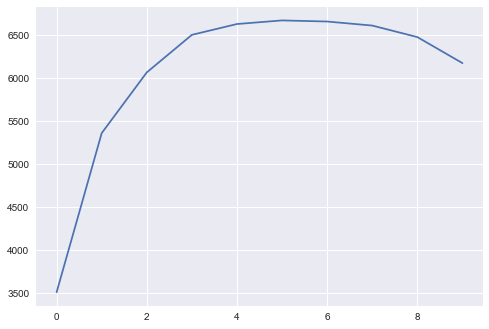

In [280]:
visualize_changes(top_groups_values, random_nodes_values)

### <font color="darkgreen">2. Temporal Network Analysis:</font> Dyads and Reciprocity